In [1]:
import pandas as pd
import utils
import warnings
import os
import skimage.util
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
genes = ["YAP1", "CORO2A", "CORO2B", "GMIP"]

### Read Profiles

In [3]:
orf_metadata_df = pd.read_csv(
    "../00.download-and-process-annotations/output/orf_metadata.tsv.gz",
    sep="\t",
    usecols=["Metadata_JCP2022", "Metadata_Symbol"],
)

orf_profiles_with_feature_names_df = utils.consensus(
    pd.read_parquet("../profiles/profiles_wellpos_cc_var_mad_outlier_orf.parquet")
    .merge(orf_metadata_df, on="Metadata_JCP2022", how="inner")
    .query('Metadata_Symbol in @genes'),
    "Metadata_Symbol",
)

orf_profiles_with_feature_names_df.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_4,BR00121552,J23,JCP2022_903067,GMIP,-4.215556,0.768919,-0.627263,1.150167,-0.505792,...,-2.115924,-2.093490,-2.104401,-2.089226,-2.076241,-2.106389,-2.092737,-2.098063,-2.101731,-2.099421
1,source_4,BR00123506,L11,JCP2022_907099,CORO2B,1.163795,0.041725,1.337077,-0.415227,1.323441,...,-1.020270,-1.028888,-1.038020,-1.044206,-1.055027,-1.037163,-1.041014,-1.046899,-1.041324,-1.033682
2,source_4,BR00123517,C16,JCP2022_906671,CORO2A,1.054504,0.553273,-0.068892,0.451936,-0.421768,...,-0.402102,-0.371214,-0.430871,-0.409410,-0.412219,-0.426773,-0.421468,-0.393912,-0.391265,-0.417312
3,source_4,BR00126520,G07,JCP2022_907106,YAP1,1.606215,2.225155,0.369793,-0.549316,0.141265,...,-0.937797,-0.958488,-1.034979,-1.001840,-1.041748,-0.984161,-0.978684,-0.960774,-0.990483,-0.959312


In [4]:
feature_names = utils.get_featurecols(orf_profiles_with_feature_names_df)

feature_name_interpretation_df = pd.DataFrame()

for feature_name in feature_names:
    df = pd.DataFrame(utils.parse_cp_features(feature_name), index=[0])
    feature_name_interpretation_df = pd.concat([feature_name_interpretation_df, df], ignore_index=True)

feature_name_interpretation_df.head()

,feature,compartment,feature_group,feature_type,channel
0,Cells_AreaShape_Area,Cells,AreaShape,Area,XNONE
1,Cells_AreaShape_BoundingBoxArea,Cells,AreaShape,BoundingBoxArea,XNONE
2,Cells_AreaShape_BoundingBoxMaximum_X,Cells,AreaShape,BoundingBoxMaximum,XNONE
3,Cells_AreaShape_BoundingBoxMaximum_Y,Cells,AreaShape,BoundingBoxMaximum,XNONE
4,Cells_AreaShape_BoundingBoxMinimum_X,Cells,AreaShape,BoundingBoxMinimum,XNONE


In [5]:
feature_group = "AreaShape"
feature_group_list = ["Texture", "Intensity", "RadialDistribution"]
compartments = ["Cells", "Cytoplasm", "Nuclei"]
channels = ["DNA", "RNA", "Mito", "ER", "AGP"]

In [6]:
compartment_feature_group_df = pd.DataFrame()

for compartment in compartments:
    feature_cols = (
        feature_name_interpretation_df.query("feature_group==@feature_group")
        .query("compartment==@compartment")
        .feature.to_list()
    )
    feature_values = orf_profiles_with_feature_names_df[feature_cols].copy().values
    id = list(orf_profiles_with_feature_names_df["Metadata_Symbol"])

    cosine_sim = utils.cosine_similarity(id, feature_values).values

    median_sim = np.median(cosine_sim[np.triu_indices(cosine_sim.shape[0], k=1)])

    df = pd.DataFrame(
        {
            "Compartment": compartment,
            "Feature_group": feature_group,
            "Similarity": median_sim,
        },
        index=[0],
    )

    compartment_feature_group_df = pd.concat(
        [compartment_feature_group_df, df], ignore_index=True
    )

compartment_feature_group_df = compartment_feature_group_df.pivot(
    index="Feature_group", columns="Compartment", values="Similarity"
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
print(compartment_feature_group_df.to_markdown())

| Feature_group   |     Cells |   Cytoplasm |   Nuclei |
|:----------------|----------:|------------:|---------:|
| AreaShape       | -0.084615 |  -0.0488807 | 0.829156 |


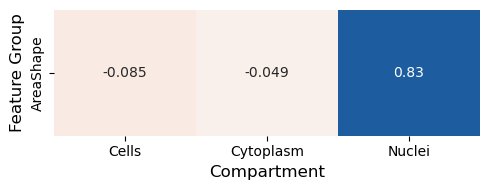

In [8]:
n_row = compartment_feature_group_df.shape[0]
n_col = compartment_feature_group_df.shape[1]
fig_width = n_row + 4
fig_height = 2

plt.figure(figsize = (fig_width, fig_height))

f = sns.heatmap(
    compartment_feature_group_df,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
    annot=True,
    cbar=None,
)

f.set(xlabel="Compartment", ylabel="Feature Group")

f.xaxis.label.set_size(12)
f.yaxis.label.set_size(12)
plt.tight_layout()
plt.savefig("figures/YAP1_subset_area_size_compartment.png")
plt.savefig("figures/YAP1_subset_area_size_compartment.svg")

In [9]:
channel_feature_group_df = pd.DataFrame()

for channel in channels:
    for feature_group in feature_group_list:
        feature_cols = (
            feature_name_interpretation_df.query("feature_group==@feature_group")
            .query("channel==@channel")
            .feature.to_list()
        )
        feature_values = orf_profiles_with_feature_names_df[feature_cols].copy().values
        id = list(orf_profiles_with_feature_names_df["Metadata_Symbol"])

        cosine_sim = utils.cosine_similarity(id, feature_values).values

        median_sim = np.median(cosine_sim[np.triu_indices(cosine_sim.shape[0], k=1)])

        df = pd.DataFrame(
            {
                "Channel": channel,
                "Feature_group": feature_group,
                "Similarity": median_sim,
            },
            index=[0],
        )

        channel_feature_group_df = pd.concat(
            [channel_feature_group_df, df], ignore_index=True
        )

channel_feature_group_df = channel_feature_group_df.pivot(
    index="Feature_group", columns="Channel", values="Similarity"
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
print(channel_feature_group_df.to_markdown())

| Feature_group      |      AGP |      DNA |       ER |       Mito |      RNA |
|:-------------------|---------:|---------:|---------:|-----------:|---------:|
| Intensity          | 0.338118 | 0.170356 | 0.292881 | -0.0390663 | 0.466935 |
| RadialDistribution | 0.39262  | 0.718204 | 0.423729 |  0.368032  | 0.644241 |
| Texture            | 0.456424 | 0.208514 | 0.197651 | -0.209481  | 0.367863 |


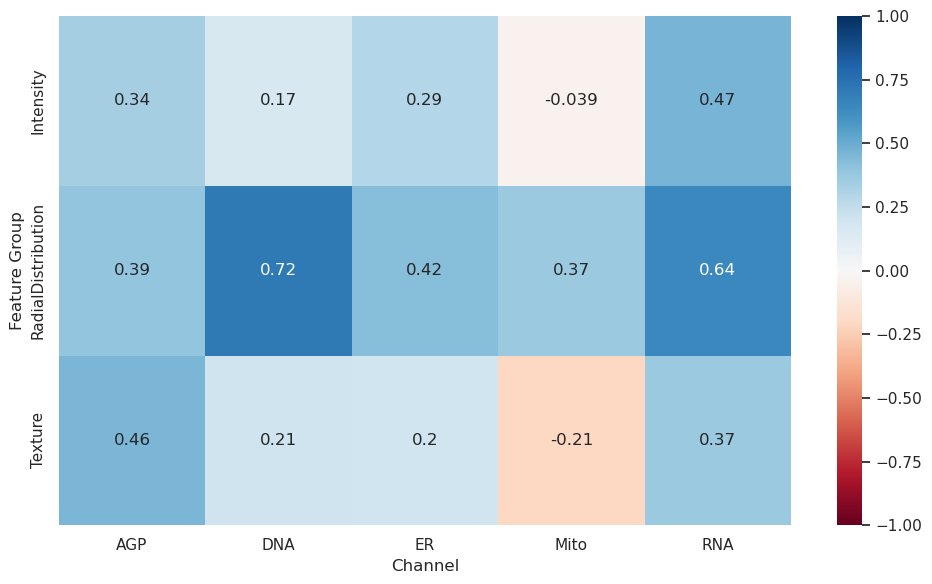

In [11]:
sns.set(font_scale=1)
plt.figure(figsize = (fig_width*2, fig_height*3))


f = sns.heatmap(
    channel_feature_group_df,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
    annot=True,
)

f.set(xlabel="Channel", ylabel="Feature Group")

f.xaxis.label.set_size(12)
f.yaxis.label.set_size(12)
plt.tight_layout()
plt.savefig("figures/YAP1_subset_feature_group_channel.png")
plt.savefig("figures/YAP1_subset_feature_group_channel.svg")

In [12]:
channels = ["DNA", "AGP", "Mito", "ER", "RNA"]
channel_perturbation_df = pd.DataFrame()
overwrite = False

In [13]:
orf_profiles_with_feature_names_df

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_4,BR00121552,J23,JCP2022_903067,GMIP,-4.215556,0.768919,-0.627263,1.150167,-0.505792,...,-2.115924,-2.093490,-2.104401,-2.089226,-2.076241,-2.106389,-2.092737,-2.098063,-2.101731,-2.099421
1,source_4,BR00123506,L11,JCP2022_907099,CORO2B,1.163795,0.041725,1.337077,-0.415227,1.323441,...,-1.020270,-1.028888,-1.038020,-1.044206,-1.055027,-1.037163,-1.041014,-1.046899,-1.041324,-1.033682
2,source_4,BR00123517,C16,JCP2022_906671,CORO2A,1.054504,0.553273,-0.068892,0.451936,-0.421768,...,-0.402102,-0.371214,-0.430871,-0.409410,-0.412219,-0.426773,-0.421468,-0.393912,-0.391265,-0.417312
3,source_4,BR00126520,G07,JCP2022_907106,YAP1,1.606215,2.225155,0.369793,-0.549316,0.141265,...,-0.937797,-0.958488,-1.034979,-1.001840,-1.041748,-0.984161,-0.978684,-0.960774,-0.990483,-0.959312


In [14]:
channel_perturbation_df = (
    orf_profiles_with_feature_names_df[
        [
            "Metadata_JCP2022",
            "Metadata_Source",
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_Symbol",
        ]
    ]
    .copy()
    .assign(pert_type="trt", modality="ORF")
)

channel_perturbation_df

,Metadata_JCP2022,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Symbol,pert_type,modality
0,JCP2022_903067,source_4,BR00121552,J23,GMIP,trt,ORF
1,JCP2022_907099,source_4,BR00123506,L11,CORO2B,trt,ORF
2,JCP2022_906671,source_4,BR00123517,C16,CORO2A,trt,ORF
3,JCP2022_907106,source_4,BR00126520,G07,YAP1,trt,ORF


In [15]:
df = pd.DataFrame()

for channel in channels:
    df = pd.concat(
        [
            df,
            channel_perturbation_df.assign(channel=channel),
        ],
        ignore_index=True,
    )

channel_perturbation_df = df.copy()
channel_perturbation_df

,Metadata_JCP2022,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Symbol,pert_type,modality,channel
0,JCP2022_903067,source_4,BR00121552,J23,GMIP,trt,ORF,DNA
1,JCP2022_907099,source_4,BR00123506,L11,CORO2B,trt,ORF,DNA
2,JCP2022_906671,source_4,BR00123517,C16,CORO2A,trt,ORF,DNA
3,JCP2022_907106,source_4,BR00126520,G07,YAP1,trt,ORF,DNA
4,JCP2022_903067,source_4,BR00121552,J23,GMIP,trt,ORF,AGP
5,JCP2022_907099,source_4,BR00123506,L11,CORO2B,trt,ORF,AGP
6,JCP2022_906671,source_4,BR00123517,C16,CORO2A,trt,ORF,AGP
7,JCP2022_907106,source_4,BR00126520,G07,YAP1,trt,ORF,AGP
8,JCP2022_903067,source_4,BR00121552,J23,GMIP,trt,ORF,Mito
9,JCP2022_907099,source_4,BR00123506,L11,CORO2B,trt,ORF,Mito


Add Batch information to the metadata

In [16]:
plate_df = pd.read_csv("../datasets/metadata/plate.csv.gz", usecols=["Metadata_Batch", "Metadata_Plate"])

channel_perturbation_df = channel_perturbation_df.merge(plate_df, on="Metadata_Plate", how="left")

channel_perturbation_df

,Metadata_JCP2022,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Symbol,pert_type,modality,channel,Metadata_Batch
0,JCP2022_903067,source_4,BR00121552,J23,GMIP,trt,ORF,DNA,2021_05_31_Batch2
1,JCP2022_907099,source_4,BR00123506,L11,CORO2B,trt,ORF,DNA,2021_05_10_Batch3
2,JCP2022_906671,source_4,BR00123517,C16,CORO2A,trt,ORF,DNA,2021_05_17_Batch4
3,JCP2022_907106,source_4,BR00126520,G07,YAP1,trt,ORF,DNA,2021_08_09_Batch11
4,JCP2022_903067,source_4,BR00121552,J23,GMIP,trt,ORF,AGP,2021_05_31_Batch2
5,JCP2022_907099,source_4,BR00123506,L11,CORO2B,trt,ORF,AGP,2021_05_10_Batch3
6,JCP2022_906671,source_4,BR00123517,C16,CORO2A,trt,ORF,AGP,2021_05_17_Batch4
7,JCP2022_907106,source_4,BR00126520,G07,YAP1,trt,ORF,AGP,2021_08_09_Batch11
8,JCP2022_903067,source_4,BR00121552,J23,GMIP,trt,ORF,Mito,2021_05_31_Batch2
9,JCP2022_907099,source_4,BR00123506,L11,CORO2B,trt,ORF,Mito,2021_05_10_Batch3


Download images from S3

In [17]:
if overwrite:
    os.system("rm -rf images")
    os.system("mkdir images")
    for jcpid in channel_perturbation_df.Metadata_JCP2022.unique():
        os.system(f"mkdir images/{jcpid}")
    utils.download_images(channel_perturbation_df)

Create Montage

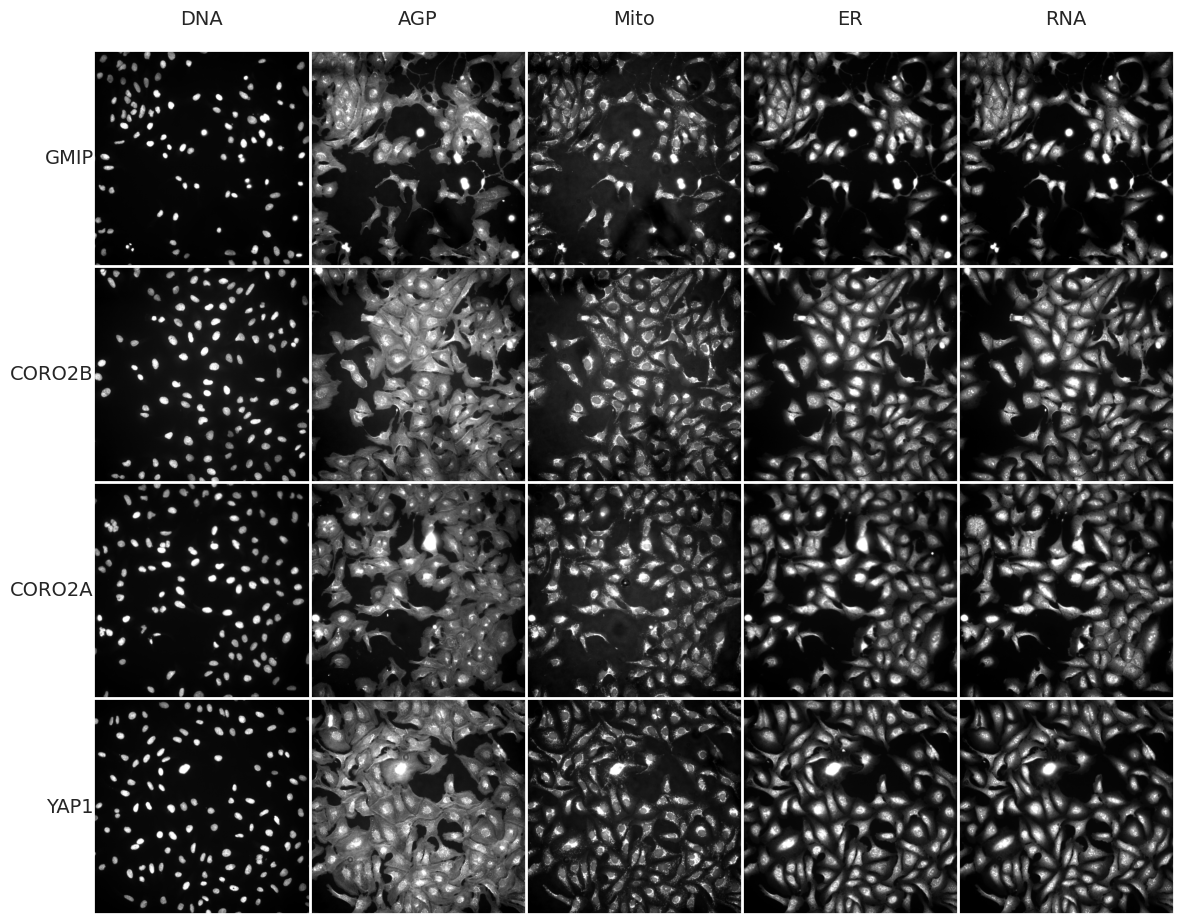

In [18]:
images = []
row_labels = []
col_labels = channels


for perturbation in channel_perturbation_df.Metadata_JCP2022.unique():
    row_labels.append(channel_perturbation_df.query(f"Metadata_JCP2022 == '{perturbation}'").Metadata_Symbol.unique()[0])
    for channel in channels:
        df = channel_perturbation_df.query(f"Metadata_JCP2022 == '{perturbation}' and channel == '{channel}'")
        for row in df.itertuples():
            filename = (
                f"images/{perturbation}/{perturbation}_{channel}.tiff"
            )
            img = skimage.io.imread(filename)
            img = utils.brighten_contrast_stretch(img)
            # img = utils.standardize_image(img)
            images.append(img)

grid_shape = (4, 5)

fig = utils.create_facet_grid_montage(
    images, row_labels, col_labels, grid_shape,
)

# Display the figure
plt.show()


#Save the figure
fig.savefig("figures/facet_grid_montage_YAP1.png", dpi=300, bbox_inches="tight")